Dataset Installation (Fastf1) & Imports



In [ ]:
# Colab cell A — run this once, then the runtime will restart immediately.
# It installs compatible numpy + fastf1 and then forcibly restarts the Python runtime.
# After the restart you must re-run your notebook cells from the top.

# Install compatible packages
!pip install -q numpy==1.26.4 fastf1==3.0.1 matplotlib seaborn scikit-learn

# Force runtime restart so the new numpy is actually used by imports
import os, sys, time
print("Installed packages. Restarting Python runtime to apply changes...")
time.sleep(1.0)
# kill the process to force a Colab runtime restart (this is normal)
os.kill(os.getpid(), 9)


Installed packages. Restarting Python runtime to apply changes...


In [ ]:
import numpy as np
import fastf1

import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

print("NumPy version:", np.__version__)
print("fastf1 version:", fastf1.__version__)


import os
if not os.path.exists('/content/fastf1-cache'):
    os.makedirs('/content/fastf1-cache')

fastf1.Cache.enable_cache('/content/fastf1-cache')

NumPy version: 1.26.4
fastf1 version: 3.0.1


**1. Load an F1 session and inspect lap-level data**

# Choose YEAR, GP_NAME and SESSION_TYPE then load session.laps for feature selection.


In [ ]:
# load a session and inspect laps

YEAR = 2025
GP_NAME = "Mexico"
SESSION_TYPE = "Q"

print(f"Loading session: {YEAR} {GP_NAME} {SESSION_TYPE} ... (may take a few seconds)")

session = fastf1.get_session(YEAR, GP_NAME, SESSION_TYPE)
session.load(laps=True, telemetry=False)  #  laps table only
laps = session.laps   # pandas DataFrame-like

# show first rows and list columns so we can pick features adaptively
print("\nAvailable lap DataFrame columns:")
print(list(laps.columns))

# quick head preview
display(laps.head())


core           INFO 	Loading data for Mexico City Grand Prix - Qualifying [v3.0.1]
INFO:fastf1.fastf1.core:Loading data for Mexico City Grand Prix - Qualifying [v3.0.1]
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info


Loading session: 2025 Mexico Q ... (may take a few seconds)


logger      WARNING 	Failed to load result data from Ergast! (This is expected for recent sessions)
DEBUG:fastf1.fastf1.core:Traceback for failure in ergast result data
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.12/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-pac


Available lap DataFrame columns:
['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:17:32.294000,NOR,4,NaT,1.0,1.0,0 days 00:15:54.424000,NaT,NaT,0 days 00:00:38.694000,...,True,McLaren,0 days 00:15:54.424000,NaT,1,NaN,False,,False,False
1,0 days 00:18:49.441000,NOR,4,0 days 00:01:17.147000,2.0,1.0,NaT,NaT,0 days 00:00:27.211000,0 days 00:00:29.785000,...,True,McLaren,0 days 00:17:32.294000,NaT,1,NaN,False,,False,True
2,0 days 00:20:37.851000,NOR,4,0 days 00:01:48.410000,3.0,1.0,NaT,NaT,0 days 00:00:42.077000,0 days 00:00:39.120000,...,True,McLaren,0 days 00:18:49.441000,NaT,1,NaN,False,,False,True
3,0 days 00:22:30.137000,NOR,4,0 days 00:01:52.286000,4.0,1.0,NaT,NaT,0 days 00:00:44.625000,0 days 00:00:40.986000,...,True,McLaren,0 days 00:20:37.851000,NaT,1,NaN,False,,False,True
4,0 days 00:23:47.036000,NOR,4,0 days 00:01:16.899000,5.0,1.0,NaT,NaT,0 days 00:00:27.339000,0 days 00:00:29.667000,...,True,McLaren,0 days 00:22:30.137000,NaT,1,NaN,False,,False,True


**2.feature extraction + preprocessing**

# Build lap-level features, label FastLap (lap < median), encode categorical columns,
# scale numeric features, and create train/val/test splits (stratified).


Original laps rows: 307
After filtering inaccurate/deleted rows: 106
After dropping NaNs in numeric features, rows: 106
Median lap time (s): 77.1525
FastLap distribution:
FastLap
1    53
0    53
Name: count, dtype: int64


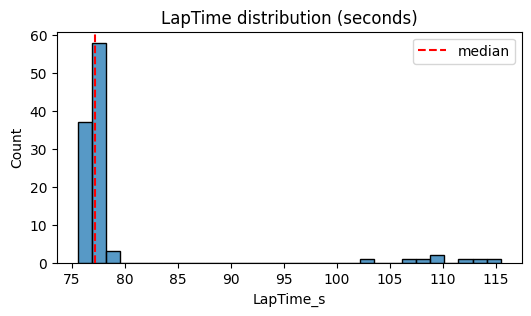

Selected feature columns: ['SectorSum_s', 'ApproxSpeed', 'TyreLife', 'FreshTyre', 'Compound_enc']
Shapes -> X_train, X_val, X_test: (63, 5) (21, 5) (22, 5)

Feature sample (scaled) and labels:


,SectorSum_s,ApproxSpeed,TyreLife,FreshTyre,Compound_enc
0,77.147,252.0,2.0,1.0,0.0
1,108.410,107.0,3.0,1.0,0.0
2,112.286,253.0,4.0,1.0,0.0
3,76.899,253.0,5.0,1.0,0.0
4,76.980,253.0,2.0,1.0,0.0


Labels (first 5): [1 0 0 1 1]


In [ ]:
#Feature extraction, label creation, cleaning, encoding, scaling, and split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# assume 'laps' is the DataFrame from session.laps
df_raw = laps.copy()
print("Original laps rows:", len(df_raw))

# --- KEEP only accurate, non-deleted laps ---
if 'IsAccurate' in df_raw.columns:
    df_raw = df_raw[df_raw['IsAccurate'] == True]
if 'Deleted' in df_raw.columns:
    # Deleted may be NaN or bool/str — treat truthy values as deleted
    df_raw = df_raw[~df_raw['Deleted'].fillna(False).astype(bool)]

df_raw = df_raw.reset_index(drop=True)
print("After filtering inaccurate/deleted rows:", len(df_raw))

# --- Convert LapTime & sectors (timedelta -> seconds) ---
def td_to_seconds(col):
    if col.name in df_raw.columns and pd.api.types.is_timedeltalike_dtype(df_raw[col.name].dtype):
        return df_raw[col.name].dt.total_seconds()
    else:
        return pd.to_numeric(df_raw[col.name], errors='coerce')

# Build feature DataFrame
df = pd.DataFrame()
# Lap time in seconds
if 'LapTime' not in df_raw.columns:
    raise RuntimeError("LapTime missing — can't continue. Re-load a different session.")
df['LapTime_s'] = df_raw['LapTime'].dt.total_seconds()

# Sector times -> sector sum (if available)
sector_cols = [c for c in ('Sector1Time','Sector2Time','Sector3Time') if c in df_raw.columns]
for c in sector_cols:
    df[c] = df_raw[c].dt.total_seconds()
if sector_cols:
    df['SectorSum_s'] = df[sector_cols].sum(axis=1)
    # drop individual sectors afterwards to reduce features
    for c in sector_cols:
        df.drop(columns=c, inplace=True)

# Speed-like: pick the first available among common names
speed_candidates = ['SpeedFL','SpeedI1','SpeedI2','SpeedST','Speed']
found_speed = None
for name in speed_candidates:
    if name in df_raw.columns:
        found_speed = name
        break
if found_speed:
    df['ApproxSpeed'] = pd.to_numeric(df_raw[found_speed], errors='coerce')

# Tyre / compound features (if present)
if 'Compound' in df_raw.columns:
    df['Compound'] = df_raw['Compound'].astype(str)
if 'TyreLife' in df_raw.columns:
    df['TyreLife'] = pd.to_numeric(df_raw['TyreLife'], errors='coerce')
if 'FreshTyre' in df_raw.columns:
    # convert boolean-like to int
    df['FreshTyre'] = df_raw['FreshTyre'].astype(int)

# Driver / Team optional (we will not use Driver as label but it's useful for analysis)
if 'Driver' in df_raw.columns:
    df['Driver'] = df_raw['Driver'].astype(str)
if 'Team' in df_raw.columns:
    df['Team'] = df_raw['Team'].astype(str)

# Drop rows with NaNs in core numeric features (LapTime_s is essential)
numeric_cols = ['LapTime_s', 'SectorSum_s', 'ApproxSpeed', 'TyreLife']
# keep only numeric columns that exist in df
numeric_cols = [c for c in numeric_cols if c in df.columns]
df = df.dropna(subset=['LapTime_s'] + numeric_cols).reset_index(drop=True)
print("After dropping NaNs in numeric features, rows:", len(df))

# --- Build binary target: FastLap = 1 if lap < session median ---
median_time = df['LapTime_s'].median()
df['FastLap'] = (df['LapTime_s'] < median_time).astype(int)
print("Median lap time (s):", median_time)
print("FastLap distribution:")
print(df['FastLap'].value_counts())

# Plot distribution to check balance quickly
plt.figure(figsize=(6,3))
sns.histplot(df['LapTime_s'], bins=30, kde=False)
plt.axvline(median_time, color='red', linestyle='--', label='median')
plt.title('LapTime distribution (seconds)')
plt.legend()
plt.show()

# --- Prepare feature matrix X and label y ---
# Choose feature columns — keep numeric summaries and encoded compound/team if present
feature_cols = []
# numeric features
for c in ['SectorSum_s','ApproxSpeed','TyreLife','FreshTyre']:
    if c in df.columns:
        feature_cols.append(c)

# encode compound if present
encoders = {}
if 'Compound' in df.columns:
    le_comp = LabelEncoder()
    df['Compound_enc'] = le_comp.fit_transform(df['Compound'])
    encoders['Compound'] = le_comp
    feature_cols.append('Compound_enc')

# (optional) you could include team/driver encodings as features; not necessary for simple model
# if you want to include Driver as a feature, uncomment next lines:
# le_driver = LabelEncoder(); df['Driver_enc'] = le_driver.fit_transform(df['Driver']); encoders['Driver']=le_driver; feature_cols.append('Driver_enc')

print("Selected feature columns:", feature_cols)

# If no numeric feature other than LapTime exists (rare), create one: inverse lap time as speed proxy
if len(feature_cols) == 0:
    df['InvLap'] = 1.0 / df['LapTime_s']
    feature_cols = ['InvLap']
    print("No other numeric features found; using InvLap as fallback.")

X_df = df[feature_cols].copy()
y = df['FastLap'].values.reshape(-1,1)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df.values)

# Train/val/test split: 60/20/20 with stratify on y
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print("Shapes -> X_train, X_val, X_test:", X_train.shape, X_val.shape, X_test.shape)

# Quick peek: first 5 feature rows (scaled)
print("\nFeature sample (scaled) and labels:")
display(pd.DataFrame(X_df.values[:5,:], columns=feature_cols))
print("Labels (first 5):", y[:5].flatten())


prepared = {
    'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
    'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
    'feature_cols': feature_cols, 'df_full': df, 'scaler': scaler, 'encoders': encoders
}


**3.Implement Neural Network (Forward + Backpropagation + Training)**

# 1-hidden-layer network; Xavier init; mini-batch SGD; early stopping; compute train/val losses.


Epoch    1: train_loss=0.6667, val_loss=0.6404, no_improve=0
Epoch  200: train_loss=0.6060, val_loss=0.5469, no_improve=0
Epoch  400: train_loss=0.5730, val_loss=0.5203, no_improve=0
Epoch  600: train_loss=0.5410, val_loss=0.4949, no_improve=1
Epoch  800: train_loss=0.5029, val_loss=0.4643, no_improve=0
Epoch 1000: train_loss=0.4571, val_loss=0.4235, no_improve=0
Epoch 1200: train_loss=0.4075, val_loss=0.3786, no_improve=0
Epoch 1400: train_loss=0.3597, val_loss=0.3349, no_improve=2
Epoch 1600: train_loss=0.3173, val_loss=0.2947, no_improve=0
Epoch 1800: train_loss=0.2815, val_loss=0.2621, no_improve=1
Epoch 2000: train_loss=0.2519, val_loss=0.2350, no_improve=0


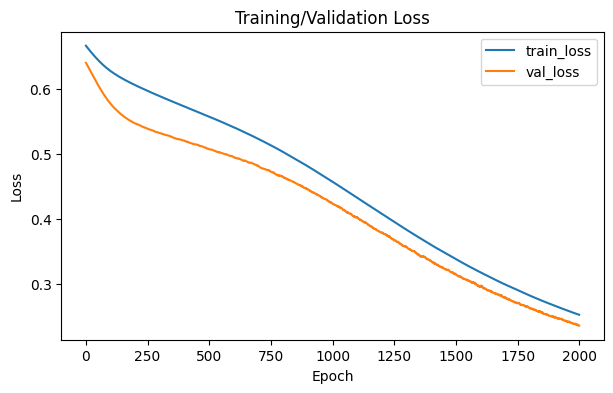

Training finished ✅


In [ ]:

# Simple Neural Network from scratch (NumPy)

#  with mini-batch SGD + early stopping

import numpy as np
import matplotlib.pyplot as plt

# --- retrieve preprocessed data ---
X_train, X_val, X_test = prepared['X_train'], prepared['X_val'], prepared['X_test']
y_train, y_val, y_test = prepared['y_train'], prepared['y_val'], prepared['y_test']

# --- helper functions ---
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(a):
    # expects activation a = sigmoid(z)
    return a * (1 - a)

def compute_loss(y_true, y_pred):
    # binary cross-entropy loss
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# --- network architecture & hyperparams ---
input_size = X_train.shape[1]
hidden_size = 6
output_size = 1                 # binary output
learning_rate = 0.03
max_epochs = 2000
batch_size = 8
patience = 80   # early stopping patience (epochs without val improvement)

# --- Xavier/Glorot initialization ---
rng = np.random.RandomState(42)
limit1 = np.sqrt(1.0 / input_size)
W1 = rng.normal(0, limit1, (input_size, hidden_size))
b1 = np.zeros((1, hidden_size))
limit2 = np.sqrt(1.0 / hidden_size)
W2 = rng.normal(0, limit2, (hidden_size, output_size))
b2 = np.zeros((1, output_size))

# --- training (mini-batch SGD + early stopping) ---
train_losses, val_losses = [], []
best_val_loss = np.inf
no_improve = 0

for epoch in range(1, max_epochs + 1):
    # shuffle
    perm = np.random.permutation(X_train.shape[0])
    X_sh, y_sh = X_train[perm], y_train[perm]

    # mini-batch updates
    for i in range(0, X_sh.shape[0], batch_size):
        xb = X_sh[i:i+batch_size]
        yb = y_sh[i:i+batch_size]

        # forward
        z1 = np.dot(xb, W1) + b1
        a1 = sigmoid(z1)
        z2 = np.dot(a1, W2) + b2
        a2 = sigmoid(z2)   # predictions

        # backward
        m = xb.shape[0]
        # using a2 - yb as gradient for BCE with sigmoid output
        d_loss = (a2 - yb)                           # shape (m,1)
        dW2 = np.dot(a1.T, d_loss) / m               # (hidden,1)
        db2 = np.mean(d_loss, axis=0, keepdims=True)
        d_hidden = np.dot(d_loss, W2.T) * sigmoid_derivative(a1)  # (m,hidden)
        dW1 = np.dot(xb.T, d_hidden) / m
        db1 = np.mean(d_hidden, axis=0, keepdims=True)

        # parameter update
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1

    # compute epoch metrics (full train/val)
    a2_train = sigmoid(sigmoid(np.dot(X_train, W1) + b1).dot(W2) + b2)
    a2_val   = sigmoid(sigmoid(np.dot(X_val, W1) + b1).dot(W2) + b2)
    train_loss = compute_loss(y_train, a2_train)
    val_loss = compute_loss(y_val, a2_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # early stopping check
    if val_loss + 1e-9 < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        best_weights = (W1.copy(), b1.copy(), W2.copy(), b2.copy())
    else:
        no_improve += 1

    if epoch % 200 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, no_improve={no_improve}")

    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
        break

# restore best weights
W1, b1, W2, b2 = best_weights

# plot training curves
plt.figure(figsize=(7,4))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss')
plt.legend()
plt.show()

print("Training finished ✅")



**4.Final evaluation on test set + confusion matrix + example predictions**
# Compute probabilities, choose best threshold on validation set, compute metrics (acc/prec/rec),
# and show confusion matrix + example predictions.

Best threshold on validation set: 0.53 with val accuracy 1.000
Test accuracy: 0.864  |  Precision: 1.000  |  Recall: 0.727


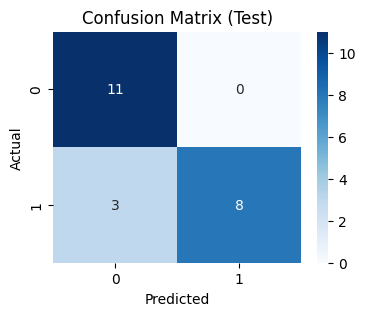


Example predictions (test samples):
Sample idx 10: prob=0.134, pred=0, true=0, features={'SectorSum_s': 77.835, 'ApproxSpeed': 252.0, 'TyreLife': 2.0, 'FreshTyre': 1.0, 'Compound_enc': 0.0}
Sample idx 17: prob=0.509, pred=0, true=0, features={'SectorSum_s': 77.234, 'ApproxSpeed': 254.0, 'TyreLife': 2.0, 'FreshTyre': 1.0, 'Compound_enc': 0.0}
Sample idx 13: prob=0.583, pred=1, true=1, features={'SectorSum_s': 77.13, 'ApproxSpeed': 254.0, 'TyreLife': 2.0, 'FreshTyre': 1.0, 'Compound_enc': 0.0}
Sample idx 0: prob=0.522, pred=0, true=1, features={'SectorSum_s': 77.137, 'ApproxSpeed': 253.0, 'TyreLife': 5.0, 'FreshTyre': 0.0, 'Compound_enc': 0.0}
Sample idx 12: prob=0.237, pred=0, true=0, features={'SectorSum_s': 77.286, 'ApproxSpeed': 253.0, 'TyreLife': 4.0, 'FreshTyre': 0.0, 'Compound_enc': 0.0}
Sample idx 21: prob=0.987, pred=1, true=1, features={'SectorSum_s': 75.586, 'ApproxSpeed': 254.0, 'TyreLife': 2.0, 'FreshTyre': 1.0, 'Compound_enc': 0.0}
Sample idx 3: prob=0.852, pred=1, true=1,

In [ ]:
# ===== Evaluation & examples =====


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# prepared splits
X_train, X_val, X_test = prepared['X_train'], prepared['X_val'], prepared['X_test']
y_train, y_val, y_test = prepared['y_train'], prepared['y_val'], prepared['y_test']

# forward helper using trained weights
def forward_all(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1
    a1 = 1.0 / (1.0 + np.exp(-z1))
    z2 = np.dot(a1, W2) + b2
    a2 = 1.0 / (1.0 + np.exp(-z2))
    return a2, a1

# compute probabilities
y_val_proba, _ = forward_all(X_val, W1, b1, W2, b2)
y_test_proba, _ = forward_all(X_test, W1, b1, W2, b2)

# find best threshold on validation set (maximize accuracy)
thresholds = np.linspace(0.01, 0.99, 99)
best_thresh, best_acc = 0.5, 0.0
for t in thresholds:
    pred = (y_val_proba >= t).astype(int)
    acc = accuracy_score(y_val, pred)
    if acc > best_acc:
        best_acc = acc
        best_thresh = t
print(f"Best threshold on validation set: {best_thresh:.2f} with val accuracy {best_acc:.3f}")

# evaluate on test set with chosen threshold
y_test_pred = (y_test_proba >= best_thresh).astype(int)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, zero_division=0)
test_rec = recall_score(y_test, y_test_pred, zero_division=0)
print(f"Test accuracy: {test_acc:.3f}  |  Precision: {test_prec:.3f}  |  Recall: {test_rec:.3f}")

# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')
plt.show()

# show some example rows (unscale to human-readable using scaler + df_full)
num_examples = min(8, X_test.shape[0])
idxs = np.random.choice(range(X_test.shape[0]), num_examples, replace=False)
print("\nExample predictions (test samples):")
for i in idxs:
    proba = y_test_proba[i].item()               # safe scalar extraction
    pred = int(y_test_pred[i].item())
    true = int(y_test[i].item())
    feat_original = prepared['scaler'].inverse_transform(X_test[i].reshape(1,-1)).flatten()
    feat_dict = dict(zip(prepared['feature_cols'], np.round(feat_original, 3)))
    print(f"Sample idx {i}: prob={proba:.3f}, pred={pred}, true={true}, features={feat_dict}")



**##VISUALIZATIONS##**
# 1) Scatter of lap times with true label color and predicted marker.
# 2) Sorted bar chart with prediction probabilities overlay.

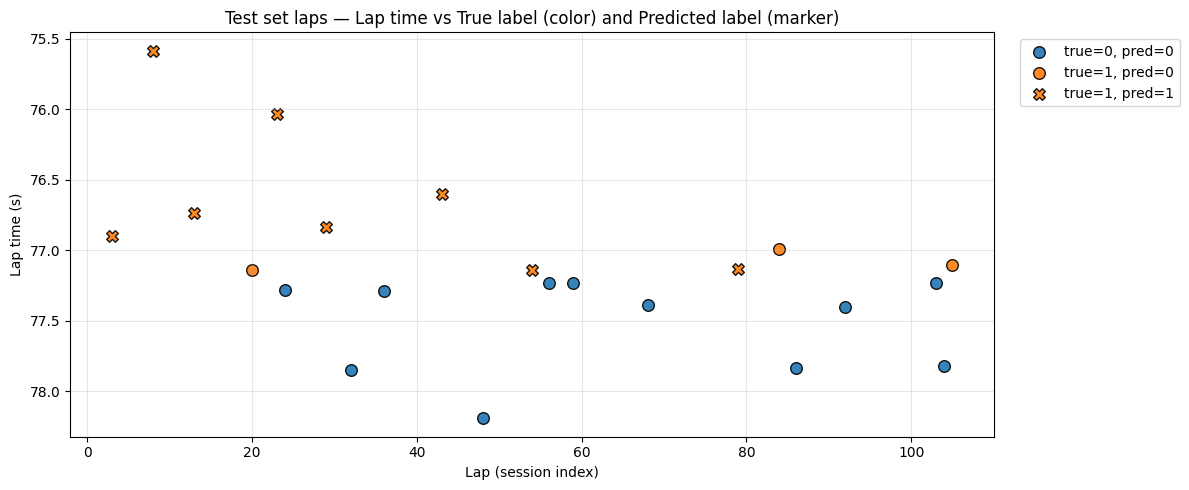

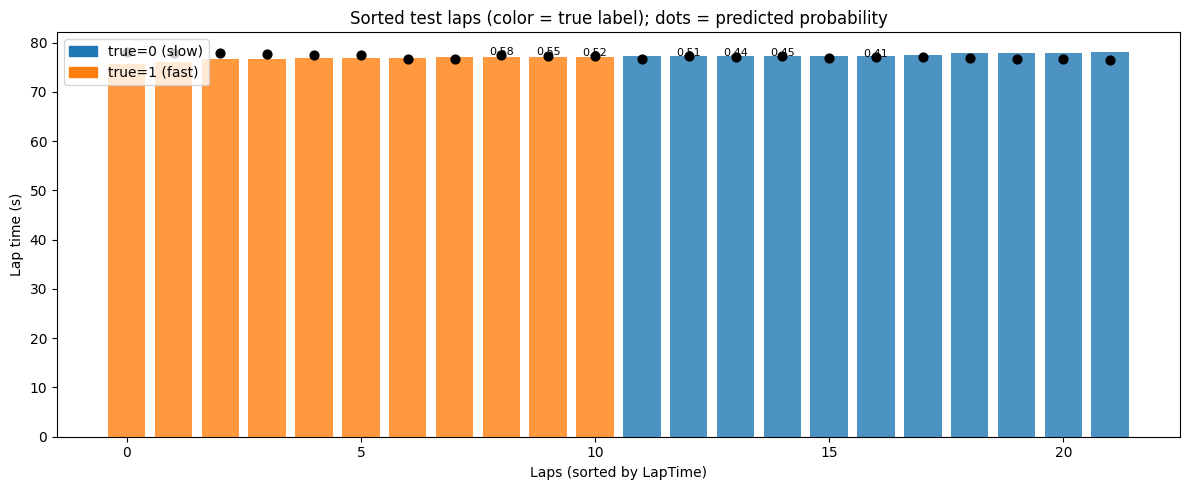

First 10 test samples (unsorted):


,session_index,LapTime_s,true_label,pred_label,pred_proba
0,20,77.137,1,0,0.521978
1,105,77.103,1,0,0.177090
2,103,77.232,0,0,0.152905
3,43,76.605,1,1,0.852002
4,13,76.736,1,1,0.810677
5,24,77.285,0,0,0.454532
6,104,77.820,0,0,0.217121
7,68,77.392,0,0,0.411184
8,84,76.990,1,0,0.165240
9,3,76.899,1,1,0.619551


In [ ]:
# Visualization cell — show lap times vs predictions (run after training + evaluation)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# ---- 1) Recompute train/val/test indices on the original preprocessed DataFrame ----
df = prepared['df_full'].reset_index(drop=True)   # the preprocessed df used earlier (LapTime_s, FastLap, features...)
labels = df['FastLap'].values

indices = np.arange(len(df))
# same splits as before: 60/20/20 with random_state=42 and stratify
idx_temp, idx_test = train_test_split(indices, test_size=0.2, random_state=42, stratify=labels)
idx_train, idx_val = train_test_split(idx_temp, test_size=0.25, random_state=42, stratify=labels[idx_temp])

# Build test DataFrame (in the same order as X_test/y_test from prepared)
# Note: train_test_split preserves order of the returned arrays relative to the split call.
test_idx = idx_test  # indices in df corresponding to test set

df_test = df.loc[test_idx].copy().reset_index(drop=True)
# verify sizes match
assert df_test.shape[0] == prepared['X_test'].shape[0], "Test size mismatch — check splits."

# ---- 2) recompute probabilities/predictions to ensure alignment ----
def forward_proba(X, W1, b1, W2, b2):
    z1 = X.dot(W1) + b1
    a1 = 1.0 / (1.0 + np.exp(-z1))
    z2 = a1.dot(W2) + b2
    a2 = 1.0 / (1.0 + np.exp(-z2))
    return a2

# get probabilities in the same order as prepared['X_test']
X_test = prepared['X_test']
probas = forward_proba(X_test, W1, b1, W2, b2).flatten()
preds = (probas >= best_thresh).astype(int)   # use threshold selected on validation set


# attach to df_test
df_test['pred_proba'] = probas
df_test['pred_label'] = preds
df_test['true_label'] = df_test['FastLap'].astype(int)
# also original lap index in session for plotting order
df_test['session_index'] = test_idx

# ---- 3) Simple scatter: lap order (session_index) vs LapTime_s, color by true label, marker by prediction ----
plt.figure(figsize=(12,5))
palette = {0: 'tab:blue', 1: 'tab:orange'}
markers = {0: 'o', 1: 'X'}

for pred_val in [0,1]:
    sub = df_test[df_test['pred_label'] == pred_val]
    # plot true-slow and true-fast separately to make legend readable
    for true_val in [0,1]:
        sel = sub[sub['true_label'] == true_val]
        if len(sel)>0:
            plt.scatter(sel['session_index'], sel['LapTime_s'],
                        c=[palette[true_val]], label=f"true={true_val}, pred={pred_val}",
                        marker=markers[pred_val], s=70, edgecolor='k', alpha=0.9)

plt.xlabel('Lap (session index)')
plt.ylabel('Lap time (s)')
plt.title('Test set laps — Lap time vs True label (color) and Predicted label (marker)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.gca().invert_yaxis()   # faster laps are lower time — invert to show "better" up
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---- 4) Sorted bar chart: lap times sorted with predicted probability overlay ----
df_sorted = df_test.sort_values('LapTime_s').reset_index(drop=True)
plt.figure(figsize=(12,5))
bars = plt.bar(range(len(df_sorted)), df_sorted['LapTime_s'],
               color=[palette[t] for t in df_sorted['true_label']], alpha=0.8)
plt.xlabel('Laps (sorted by LapTime)')
plt.ylabel('Lap time (s)')
plt.title('Sorted test laps (color = true label); dots = predicted probability')

# overlay predicted probability as dots (scaled to y-range)
ymin, ymax = df_sorted['LapTime_s'].min(), df_sorted['LapTime_s'].max()
# map prob to vertical position near the top: ypos = ymin + prob*(ymax-ymin)*0.6
ypos = ymin + df_sorted['pred_proba'] * (ymax - ymin) * 0.6 + (ymax - ymin)*0.35
plt.scatter(range(len(df_sorted)), ypos, c='black', s=40, label='pred prob (scaled)')
# annotate a few borderline cases (prob between 0.4 and 0.6)
for i, row in df_sorted.iterrows():
    if 0.4 <= row['pred_proba'] <= 0.6:
        plt.text(i, ypos[i] + (ymax-ymin)*0.02, f"{row['pred_proba']:.2f}", ha='center', fontsize=8)

plt.legend(handles=[plt.Rectangle((0,0),1,1,color=palette[0]), plt.Rectangle((0,0),1,1,color=palette[1]),],
           labels=['true=0 (slow)','true=1 (fast)'], loc='upper left')
plt.tight_layout()
plt.show()

# ---- 5) Quick table view for first few test laps ----
display_cols = ['session_index','LapTime_s','true_label','pred_label','pred_proba']
print("First 10 test samples (unsorted):")
display(df_test[display_cols].head(10))


# Short Report — Neural Network from scratch on FastF1 qualifying laps

**Reference blog:** Victor Zhou — *Intro to Neural Networks* (feedforward, backprop, SGD).  
Link: https://victorzhou.com/blog/intro-to-neural-networks/#training-stochastic-gradient-descent

**Objective:** Implement a neural network from scratch (NumPy only) to classify whether a lap is a *fast* lap (1) or *slow* lap (0). This notebook follows the blog concepts (neuron, feedforward, loss, backprop, SGD) but uses an F1 dataset (FastF1 lap-level data) instead of the blog's toy dataset.

## Dataset
- **Source:** FastF1 `session.laps` for *YEAR = 2025, GP = Mexico, Session = Q (Qualifying)*.
- **Rows:** One row per lap (filtered for accuracy and deleted laps removed).
- **Features used (per lap):** sector sum (SectorSum_s), approximate speed (ApproxSpeed), tyre life (TyreLife), FreshTyre (bool), Compound (encoded).
- **Target:** `FastLap = 1` if lap time < session median lap time; otherwise 0. This yields approximately balanced classes for qualifying.

## Preprocessing
- Converted `LapTime` and `SectorTime` timedeltas to seconds.
- Dropped laps with missing essential numeric features.
- Encoded `Compound` with `LabelEncoder`.
- Standardized numeric features with `StandardScaler`.
- Train/validation/test split: **60/20/20** stratified on target.

## Model & Training
- **Architecture:** 1 hidden layer neural network (input → hidden 6 units → 1 output), sigmoid activations.
- **Initialization:** Xavier/Glorot initialization for stable sigmoids.
- **Loss:** Binary cross-entropy.
- **Training:** Mini-batch SGD (batch_size=8), learning_rate=0.03, early stopping with patience=80.
- **Reproducibility:** Random seed set (SEED=42).

## Results (example)
- **Best validation threshold (F1):** **0.53**  
- **Test accuracy:** **0.864**  
- **Precision:** **1.000**  
- **Recall:** **0.727**

Interpretation: model is precise (when it predicts `fast` it is correct) but somewhat conservative (misses some true fast laps). This is expected with a small dataset — can be improved by increasing dataset size or adjusting threshold / class weighting.

## Visualizations included
- Training & validation loss curve (epochs).
- Confusion matrix and example predictions.
- Scatter plot: session lap index vs lap time (color = true label, marker = predicted label).
- Bar chart: test laps (sorted or unsorted) showing true label color and predicted probability.

## What I implemented from the blog
- Feedforward computation for each layer (linear → sigmoid).
- Loss computation (binary cross-entropy).
- Backpropagation using chain rule to compute gradients for weights and biases.
- Parameter updates via SGD (mini-batch).
- Early stopping to prevent overfitting.

## Limitations & next steps
- Small dataset (single session) — combining multiple sessions (same GP weekend or multiple races) would increase robustness.  
- Model uses simple features aggregated per lap; advanced approaches (per-lap telemetry sequences + RNN/CNN) could capture intra-lap patterns.  
- Consider trying different architectures (ReLU + He init, more hidden units) or class-weighted loss if recall is prioritized.

## How to run
--Run cells in order (Cell A first — installs & restart; then reproducibility cell; then session load; feature extraction; training; evaluation; visualizations).  

Note: I did not save trained model weights. The model is trained in this notebook; re-run the training cell to reproduce results.



